# SAM Inference

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install ultralytics

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-32qrovsg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-32qrovsg
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=2bcaa7f39c13b272db082a2018fd34efa6a1e83300ac1cd140d47618da82477a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ejpggma7/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 2

In [ ]:
import numpy as np
import torch
import cv2
import shutil
import matplotlib.pyplot as plt
import os
import random
import matplotlib.patches as patches
from ultralytics import YOLO
import matplotlib.colors as mcolors
from DataPreprocess import ImageData, MaskData, Reshape

In [ ]:
from helper import Helper

helperfns = Helper()

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
ROOT_DIR = '/content/gdrive/My Drive/coding/'

In [ ]:
folder_path = ROOT_DIR + 'dl_challenge'

samimages = ImageData()
sammasks = MaskData()
resize_data = Reshape(256, 256)

In [ ]:
samimages.read_all_files(folder_path)
sammasks.read_all_files(folder_path)

combined_masks = resize_data.combine_masks(sammasks.masks)

In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_temp, masks_train, masks_temp, combined_masks_train, combined_masks_temp = train_test_split(
    samimages.images, sammasks.masks, combined_masks, test_size=0.2, random_state=42
)

images_val, images_test, masks_val, masks_test, combined_masks_val, combined_masks_test = train_test_split(
    images_temp, masks_temp, combined_masks_temp, test_size=0.5, random_state=42
)

In [ ]:
model_path = ROOT_DIR + 'yolov8/models/best.pt'
model = YOLO(model_path)

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = ROOT_DIR + "SAM/models/best.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
img_num = random.randint(0, len(images_test) - 1)
infer_image = images_test[img_num]
infer_mask = masks_test[img_num]
infer_combined_mask = combined_masks_test[img_num]

In [ ]:
results = model(infer_image)
yolo_boxes = results[0].boxes

yolo_boxes_list = yolo_boxes.xyxy.cpu().numpy().tolist()


0: 512x640 4 objects, 22.1ms
Speed: 4.7ms preprocess, 22.1ms inference, 4.3ms postprocess per image at shape (1, 3, 512, 640)


In [ ]:
predictor.set_image(infer_image)

In [ ]:
input_boxes = torch.tensor(yolo_boxes_list, device=predictor.device)

In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, infer_image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [ ]:
sam_seg_mask = masks.squeeze(1).cpu().numpy()

# Yolo inferance

In [ ]:
model_path = ROOT_DIR + 'yolov8_instance_seg/models/best.pt'

model = YOLO(model_path)

In [ ]:
results = model(infer_image)

mask_list = []

H, W, _ = infer_image.shape

for i, result in enumerate(results):
    for j, mask in enumerate(result.masks.data):
        mask = (mask.cpu().numpy() * 255).astype(np.uint8)
        mask = cv2.resize(mask, (W, H))

        mask_list.append(np.expand_dims(mask, axis=0))

final_mask_array = np.stack(mask_list, axis=0)


0: 512x640 4 objects, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


In [ ]:
yolo_seg_mask = final_mask_array.squeeze(1)

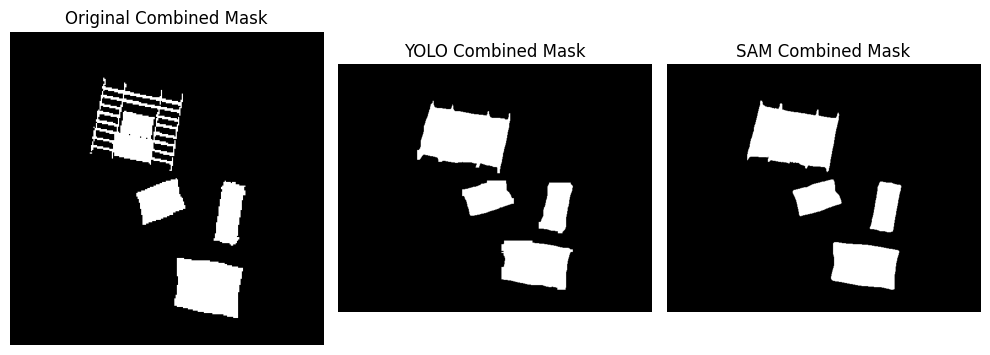

In [ ]:
yolo_combined_mask = helperfns.combine_masks(yolo_seg_mask)
sam_combined_mask = helperfns.combine_masks(sam_seg_mask)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(infer_combined_mask, cmap='gray')
plt.title('Original Combined Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(yolo_combined_mask, cmap='gray')
plt.title('YOLO Combined Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sam_combined_mask, cmap='gray')
plt.title('SAM Combined Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

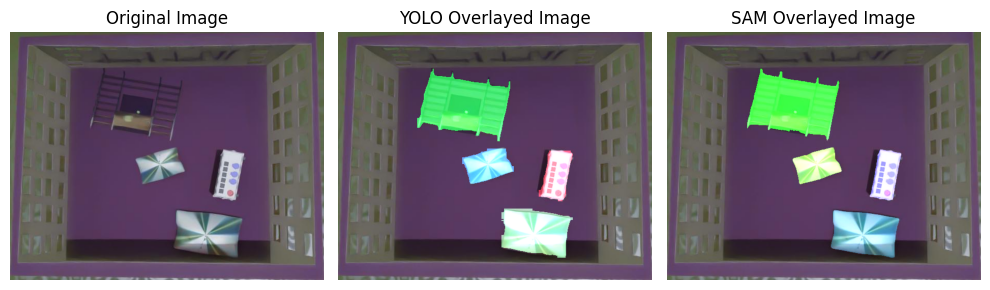

In [ ]:
yolo_overlayed_image = helperfns.overlay_masks_on_image(infer_image.copy(), yolo_seg_mask)
sam_overlayed_image = helperfns.overlay_masks_on_image(infer_image.copy(), sam_seg_mask)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(infer_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(yolo_overlayed_image, cmap='gray')
plt.title('YOLO Overlayed Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sam_overlayed_image, cmap='gray')
plt.title('SAM Overlayed Image')
plt.axis('off')

plt.tight_layout()
plt.show()